<a href="https://colab.research.google.com/github/neermesh/dataPreprocessing/blob/master/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

In [0]:
from pandas_datareader import data as pdr
data = pdr.get_data_yahoo('CIPLA.NS')  

In [3]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,339.500000,336.000000,338.000000,337.549988,635013.0,319.540070
2010-01-05,342.399994,330.500000,338.549988,331.500000,1664976.0,313.812958
2010-01-06,348.899994,330.350006,332.000000,344.899994,3580916.0,326.497986
2010-01-07,350.399994,340.500000,346.000000,342.049988,1555841.0,323.800049
2010-01-08,346.500000,340.200012,345.000000,341.100006,913410.0,322.900757
...,...,...,...,...,...,...
2020-01-21,479.549988,472.200012,478.950012,473.399994,1448808.0,473.399994
2020-01-22,480.299988,470.250000,474.500000,471.600006,2380518.0,471.600006
2020-01-23,475.850006,459.350006,464.500000,465.149994,5783699.0,465.149994


In [4]:
data.shape

(2480, 6)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


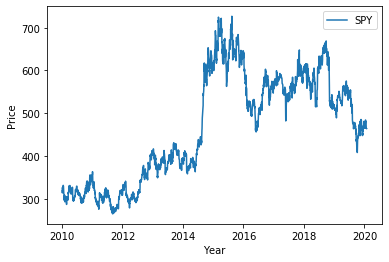

In [5]:
plt.plot(data.index, data['Adj Close'])
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(['SPY'])
plt.show()

((array([-3.45069891, -3.20360141, -3.06676894, ...,  3.06676894,
          3.20360141,  3.45069891]),
  array([-0.08825631, -0.07861905, -0.07255802, ...,  0.07106212,
          0.07403819,  0.07624075])),
 (0.015377388802958875, 0.00027197479612712193, 0.985421683609324))

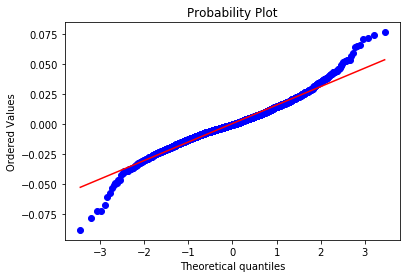

In [6]:
#Check for normal distribution
import scipy.stats as stats
import pylab 
data['pct_chg'] = data['Adj Close'].pct_change()[1:]
data.dropna(inplace=True, axis=0)

stats.probplot(data['pct_chg'], dist="norm", plot=pylab)


((array([-3.45059002, -3.20348525, -3.06664835, ...,  3.06664835,
          3.20348525,  3.45059002]),
  array([-0.09239637, -0.0818817 , -0.07532504, ...,  0.0686508 ,
          0.07142556,  0.07347418])),
 (0.015363734265117676, 0.00015804118955682302, 0.9856012806991931))

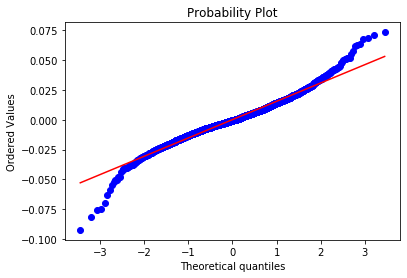

In [7]:
#Log transformation
data['lrets'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))
data.dropna(inplace=True, axis=0)
stats.probplot(data['lrets'], dist="norm", plot=pylab)

In [0]:
#MACD(Moving Average Convergence/Divergence oscillator)
def MACD(df, period1, period2, periodSignal):
    EMA1 = pd.DataFrame.ewm(df,span=period1).mean() # Provides exponential weighted functions
    EMA2 = pd.DataFrame.ewm(df,span=period2).mean() 
    
    MACD = EMA1-EMA2
    Signal = pd.DataFrame.ewm(MACD,periodSignal).mean()
    
    Histogram = MACD-Signal
    return Histogram

In [0]:
#Stochastics oscillator
def stochastics_oscillator(df,period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

In [0]:
#Average True Range
def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()

In [11]:
macd = MACD(data['Adj Close'], 12, 26,9)
macd.rename(columns={'Close':'MACD'}, inplace=True)
macd.tail()

Date
2020-01-21    0.469529
2020-01-22   -0.144524
2020-01-23   -1.062825
2020-01-27   -1.752324
2020-01-28   -2.220595
dtype: float64

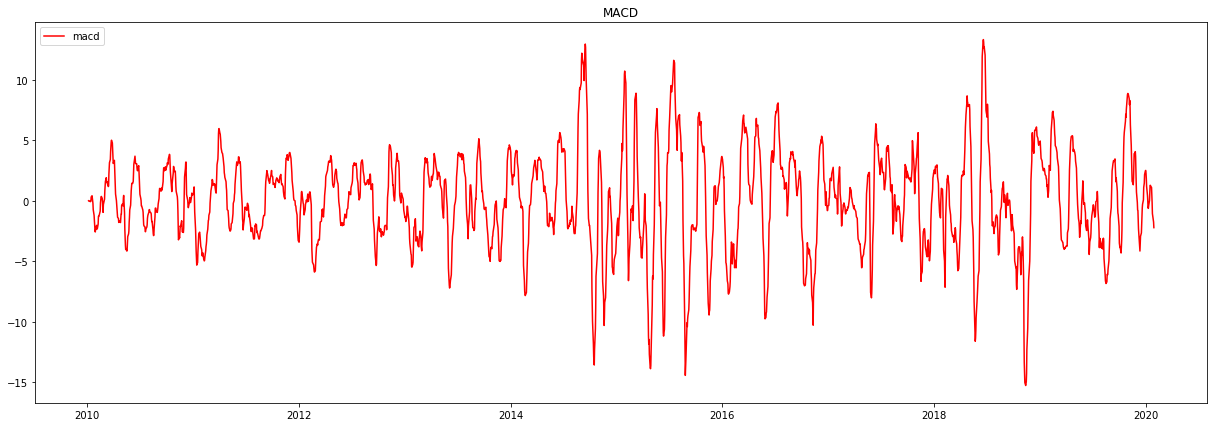

In [12]:
plt.figure(figsize=(21,7))
plt.plot(macd,label='macd',color='red')
plt.title('MACD')
plt.legend(loc='upper left')
plt.show()

In [13]:
stochastics = stochastics_oscillator(data['Adj Close'], 14)
stochastics.rename(columns={'Close':'Stochastics'}, inplace=True)
stochastics.tail()

Date
2020-01-21    44.358943
2020-01-22    35.128236
2020-01-23     2.051251
2020-01-27     0.000000
2020-01-28     0.000000
dtype: float64

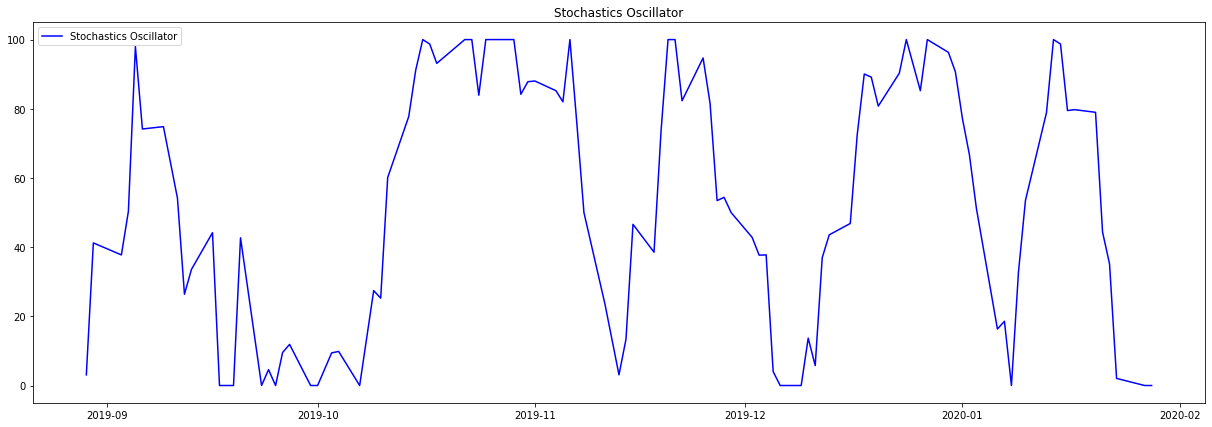

In [14]:


plt.figure(figsize=(21,7))
plt.plot(stochastics[-100:],label='Stochastics Oscillator',color='blue')
plt.title('Stochastics Oscillator')
plt.legend(loc='upper left')
plt.show()



In [15]:
atr = ATR(data,14)
atr.rename(columns={0:'ATR'}, inplace=True)
atr.tail()

,ATR
Date,
2020-01-21,7.949982
2020-01-22,10.049988
2020-01-23,16.500000
2020-01-27,12.299988
2020-01-28,9.049988


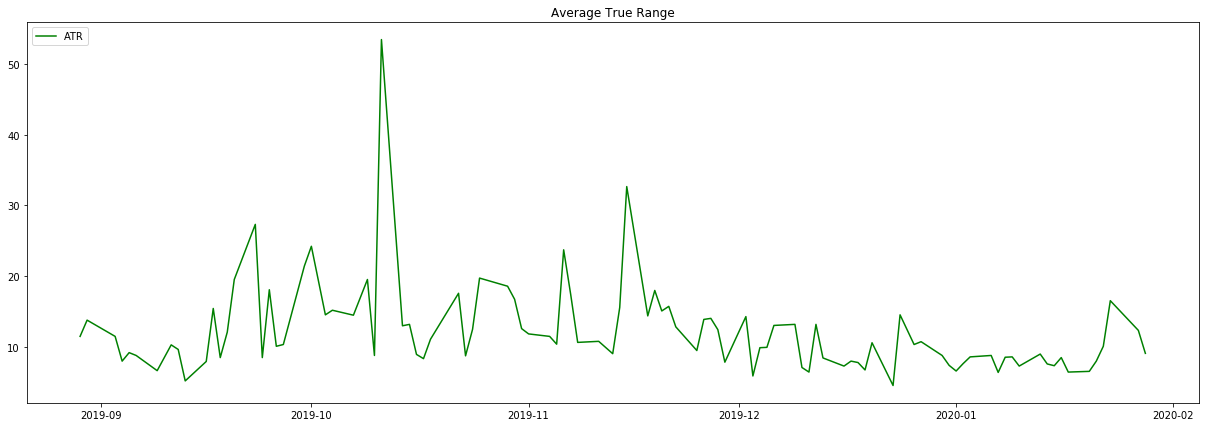

In [16]:


plt.figure(figsize=(21,7))
plt.plot(atr[-100:],label='ATR',color='green')
plt.title('Average True Range')
plt.legend(loc='upper left')
plt.show()



In [0]:
data = pd.concat([data, macd, stochastics, atr], axis=1)

In [0]:
data.rename(columns={0:'MACD', 1:'stochastics'}, inplace=True)

In [19]:


data.drop(['pct_chg', 'H-L', 'H-PC', 'L-PC'], axis=1 , inplace=True)
data.tail()



,High,Low,Open,Close,Volume,Adj Close,lrets,MACD,stochastics,ATR
Date,,,,,,,,,,
2020-01-21,479.549988,472.200012,478.950012,473.399994,1448808.0,473.399994,-0.014158,0.469529,44.358943,7.949982
2020-01-22,480.299988,470.250000,474.500000,471.600006,2380518.0,471.600006,-0.003810,-0.144524,35.128236,10.049988
2020-01-23,475.850006,459.350006,464.500000,465.149994,5783699.0,465.149994,-0.013771,-1.062825,2.051251,16.500000
2020-01-27,466.500000,454.200012,457.500000,464.450012,5848968.0,464.450012,-0.001506,-1.752324,0.000000,12.299988
2020-01-28,468.000000,458.950012,465.000000,464.250000,1032549.0,464.250000,-0.000431,-2.220595,0.000000,9.049988


In [20]:
data

,High,Low,Open,Close,Volume,Adj Close,lrets,MACD,stochastics,ATR
Date,,,,,,,,,,
2010-01-06,348.899994,330.350006,332.000000,344.899994,3580916.0,326.497986,0.039627,0.000000,NaN,18.549988
2010-01-07,350.399994,340.500000,346.000000,342.049988,1555841.0,323.800049,-0.008298,-0.028672,NaN,9.899994
2010-01-08,346.500000,340.200012,345.000000,341.100006,913410.0,322.900757,-0.002781,-0.046162,NaN,6.299988
2010-01-11,346.200012,341.000000,343.799988,342.299988,741426.0,324.036713,0.003512,-0.016175,NaN,5.200012
2010-01-12,344.399994,336.549988,342.299988,339.649994,1083070.0,321.528076,-0.007772,-0.076782,NaN,7.850006
...,...,...,...,...,...,...,...,...,...,...
2020-01-21,479.549988,472.200012,478.950012,473.399994,1448808.0,473.399994,-0.014158,0.469529,44.358943,7.949982
2020-01-22,480.299988,470.250000,474.500000,471.600006,2380518.0,471.600006,-0.003810,-0.144524,35.128236,10.049988
2020-01-23,475.850006,459.350006,464.500000,465.149994,5783699.0,465.149994,-0.013771,-1.062825,2.051251,16.500000


In [21]:
data.dropna(axis=0, inplace=True)
data

,High,Low,Open,Close,Volume,Adj Close,lrets,MACD,stochastics,ATR
Date,,,,,,,,,,
2010-01-25,332.700012,320.000000,325.000000,326.950012,527544.0,309.505737,-0.010194,-1.208561,0.000000,12.700012
2010-01-27,326.850006,310.000000,326.000000,313.500000,1479710.0,296.773315,-0.042008,-2.130173,0.000000,16.950012
2010-01-28,328.000000,314.200012,316.100006,317.850006,2473512.0,300.891205,0.013780,-2.437950,11.852789,14.500000
2010-01-29,323.750000,303.000000,318.100006,317.200012,2282638.0,300.275940,-0.002047,-2.578116,10.081832,20.750000
2010-02-01,327.899994,316.500000,319.000000,326.049988,964639.0,308.653717,0.027518,-2.099757,34.196134,11.399994
...,...,...,...,...,...,...,...,...,...,...
2020-01-21,479.549988,472.200012,478.950012,473.399994,1448808.0,473.399994,-0.014158,0.469529,44.358943,7.949982
2020-01-22,480.299988,470.250000,474.500000,471.600006,2380518.0,471.600006,-0.003810,-0.144524,35.128236,10.049988
2020-01-23,475.850006,459.350006,464.500000,465.149994,5783699.0,465.149994,-0.013771,-1.062825,2.051251,16.500000


In [22]:
data.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
data.head()

,Volume,Adj Close,lrets,MACD,stochastics,ATR
Date,,,,,,
2010-01-25,527544.0,309.505737,-0.010194,-1.208561,0.000000,12.700012
2010-01-27,1479710.0,296.773315,-0.042008,-2.130173,0.000000,16.950012
2010-01-28,2473512.0,300.891205,0.013780,-2.437950,11.852789,14.500000
2010-01-29,2282638.0,300.275940,-0.002047,-2.578116,10.081832,20.750000
2010-02-01,964639.0,308.653717,0.027518,-2.099757,34.196134,11.399994


In [0]:
import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

import math
from sklearn.preprocessing import RobustScaler
from collections import deque

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
data['Y'] = data.lrets.shift(-1)
data.dropna(axis=0, inplace=True)
data

,Volume,Adj Close,lrets,MACD,stochastics,ATR,Y
Date,,,,,,,
2010-01-25,527544.0,309.505737,-0.010194,-1.208561,0.000000,12.700012,-0.042008
2010-01-27,1479710.0,296.773315,-0.042008,-2.130173,0.000000,16.950012,0.013780
2010-01-28,2473512.0,300.891205,0.013780,-2.437950,11.852789,14.500000,-0.002047
2010-01-29,2282638.0,300.275940,-0.002047,-2.578116,10.081832,20.750000,0.027518
2010-02-01,964639.0,308.653717,0.027518,-2.099757,34.196134,11.399994,-0.038454
...,...,...,...,...,...,...,...
2020-01-20,1206931.0,480.149994,-0.000312,1.097539,78.974328,6.500000,-0.014158
2020-01-21,1448808.0,473.399994,-0.014158,0.469529,44.358943,7.949982,-0.003810
2020-01-22,2380518.0,471.600006,-0.003810,-0.144524,35.128236,10.049988,-0.013771


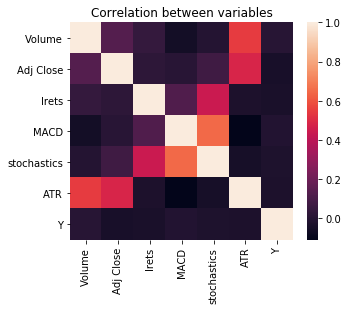

In [25]:
corr = data.corr('pearson')
f, ax = plt.subplots(figsize=(5, 4))
plt.title("Correlation between variables")
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [26]:
corr

,Volume,Adj Close,lrets,MACD,stochastics,ATR,Y
Volume,1.000000,0.133424,0.043371,-0.049432,-0.003231,0.548133,0.003238
Adj Close,0.133424,1.000000,0.022916,0.008945,0.073156,0.485987,-0.036855
lrets,0.043371,0.022916,1.000000,0.120749,0.442549,-0.026595,-0.033855
MACD,-0.049432,0.008945,0.120749,1.000000,0.649218,-0.109754,-0.009569
stochastics,-0.003231,0.073156,0.442549,0.649218,1.000000,-0.042678,-0.021052
ATR,0.548133,0.485987,-0.026595,-0.109754,-0.042678,1.000000,-0.024669
Y,0.003238,-0.036855,-0.033855,-0.009569,-0.021052,-0.024669,1.000000
